### Preparing HDFS
Using magic

Create input folder on HDFS if not exists

Copy from data from local

## Assessment Stage 2: Wrangling

In [1]:
!pwd
! hadoop fs -mkdir -p  /tmp/rs_input
! hadoop fs -put   -p  ./../data-raw/Melbourne_housing_FULL.csv             /tmp/rs_input/raw.csv
! hadoop fs -ls        /tmp/rs_input/

/home/sandpit/big-data-realestate/scripts

Found 1 items


-rw-r--r--   1 root root    5018236 2020-05-26 00:56 /tmp/rs_input/raw.csv




 #### Check Spark Parameters

In [2]:
sc.getConf.toDebugString

Intitializing Scala interpreter ...

Spark Web UI available at http://2f12d53e6695:4040
SparkContext available as 'sc' (version = 2.4.5, master = local[*], app id = local-1591621925163)
SparkSession available as 'spark'


res0: String =
spark.app.id=local-1591621925163
spark.app.name=spylon-kernel
spark.driver.host=2f12d53e6695
spark.driver.memory=8g
spark.driver.port=44437
spark.executor.id=driver
spark.executor.memory=8g
spark.executor.memoryOverhead=8g
spark.master=local[*]
spark.memory.offHeap.enabled=true
spark.memory.offHeap.size=8g
spark.network.timeout=10000000
spark.rdd.compress=True
spark.repl.class.outputDir=/tmp/tmp9tsp3cmg
spark.repl.class.uri=spark://2f12d53e6695:44437/classes
spark.serializer.objectStreamReset=100
spark.storage.memoryFraction=0.4
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


#### Read  file 

In [3]:
//load raw into df
val df_raw = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/rs_input/raw.csv")


df_raw: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [4]:
df_raw.count()

res1: Long = 34857


#### Load data 

In [5]:
//only select columns we need now
var df_working= df_raw.select("Price",
                          "Method",
                          "Type",
                          "Distance",
                          "Rooms",
                          "Bathroom",
                          "Car",
                          "Landsize",
                          "Lattitude",
                          "Longtitude",    
                          "Suburb",
                          "Address",
                          "Date")


//add meaningful to column names
df_working = df_working.withColumnRenamed("Method","MethodOfSale")
    .withColumnRenamed("Distance","DistanceFromCBD")
    .withColumnRenamed("Type","PropertyType")
    .withColumnRenamed("Lattitude","Latitude")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]
df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


#### Filter out  "#N/A" records

In [6]:
//when profiling there are a number of columns with a "#N/A" which need to be removed
df_working = df_working.filter($"DistanceFromCBD" =!= "#N/A")

df_working: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


#### Change type of columns "Price", "DistanceFromCBD" & "Landsize" to Double, "Rooms", "Bathroom", "Car" to Int

In [7]:
df_working = df_working.withColumn("Price",col("Price").cast("Double"))
    .withColumn("Rooms",col("Rooms").cast("Int"))
    .withColumn("DistanceFromCBD",col("DistanceFromCBD").cast("Double"))
    .withColumn("Bathroom",col("Bathroom").cast("Int"))
    .withColumn("Car",col("Car").cast("Int"))
    .withColumn("Landsize",col("Landsize").cast("Double"))
    .withColumn("Latitude",col("Latitude").cast("Double"))
    .withColumn("Longtitude",col("Longtitude").cast("Double"))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Make First Letter of Suburb Upper Case

In [8]:
// make first letter of suburb upper case
df_working= df_working.withColumn("Suburb", initcap(col("Suburb")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Split Address on Street and Suffix

In [9]:
df_working.select("Address").show(10)

+------------------+
|           Address|
+------------------+
|     68 Studley St|
|      85 Turner St|
|   25 Bloomburg St|
|18/659 Victoria St|
|      5 Charles St|
|  40 Federation La|
|       55a Park St|
|      16 Maugie St|
|      53 Turner St|
|      99 Turner St|
+------------------+
only showing top 10 rows



In [10]:
//split address on Street name and Suffix
df_working = df_working.withColumn("StreetName",concat(split(col("Address")," ").getItem(1)
                                   , lit(" "),split(col("Address")," ").getItem(2))).drop("Address")

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [11]:
df_working.select("StreetName").show(10)

+-------------+
|   StreetName|
+-------------+
|   Studley St|
|    Turner St|
| Bloomburg St|
|  Victoria St|
|   Charles St|
|Federation La|
|      Park St|
|    Maugie St|
|    Turner St|
|    Turner St|
+-------------+
only showing top 10 rows



#### Make First Letter of Street upper

In [12]:
// make first letter of Street upper case
df_working= df_working.withColumn("StreetName", initcap(col("StreetName")))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Convert Property Type to upper

In [13]:
df_working = df_working.withColumn("PropertyType", upper(col("PropertyType")))


df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Remove Bad Landsize Data

In [14]:
//drop all properties with land area less than 12 sqm 
df_working = df_working.filter(!($"Landsize"<12))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [15]:
//drop rows where type = h and landsize < 50 sqm
df_working = df_working.filter(!($"Landsize"<50 && $"PropertyType"===1))

df_working: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Filter Null Values

In [16]:
val df_not_null = df_working.na.drop()

df_not_null: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [17]:
df_not_null.printSchema()

root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



#### Write Down Clean Data:

In [18]:
! hadoop fs -mkdir -p /tmp/output

In [19]:
val df_output = df_not_null.coalesce(1)
   .write
   .format("csv")
   .option("header","true")
   .mode("overwrite").option("sep",",")
   .save("hdfs://localhost:9000/tmp/output")

df_output: Unit = ()


#### Save the Clean Data to Disk

In [20]:
! hadoop fs -mkdir -p /tmp/output
! hadoop fs -copyToLocal /tmp/output/\*.csv ./../data-clean/cleanMelbourneData.csv

copyToLocal: `./../data-clean/cleanMelbourneData.csv': File exists




## Assessment Stage 3: Modelling

In [21]:
// use the set wrangled from 
var df_clean = df_not_null

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


In [22]:
df_clean.cache()
df_clean.printSchema()
df_clean.count()


root
 |-- Price: double (nullable = true)
 |-- MethodOfSale: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longtitude: double (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



res5: Long = 15710


### Construct vectors from attributes
#### Transform Sale Date into a numeric value

In [23]:
df_clean = df_clean.withColumn("Date",unix_timestamp($"Date", "dd/mm/yyyy"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 11 more fields]


#### Set StringIndexer for Categorical Variables

In [24]:
import org.apache.spark.ml.feature.{FeatureHasher,StandardScaler,OneHotEncoder,VectorAssembler}
import org.apache.spark.ml.feature.{OneHotEncoderEstimator,StringIndexer,VectorIndexer}
import org.apache.spark.ml.linalg.Vectors

//define string indexers on categorical values
val suburbIndexer = new StringIndexer()
    .setInputCol("Suburb")
    .setOutputCol("SuburbIndex")
    .setHandleInvalid("keep")

val streetNameIndexer = new StringIndexer()
    .setInputCol("StreetName")
    .setOutputCol("StreetNameIndex")
    .setHandleInvalid("keep")

//define string indexers
val propertyTypeIndexer = new StringIndexer()
    .setInputCol("PropertyType")
    .setOutputCol("PropertyTypeIndex")
    .setHandleInvalid("keep")

val methodOfSaleIndexer = new StringIndexer()
    .setInputCol("MethodOfSale")
    .setOutputCol("MethodOfSaleIndex")
    .setHandleInvalid("keep")


//set the categorical names
val categoricalFeatureColumnNames= Array("MethodOfSaleIndex",
            "PropertyTypeIndex",
            "SuburbIndex",
            "StreetNameIndex")

val featureColumnNames= Array("MethodOfSale",
            "PropertyType",
             "Suburb",                 
            "StreetName",
            "DistanceFromCBD",
            "Rooms",
            "Bathroom",
            "Car",
            "Landsize",
            "Latitude",
            "Longtitude",
            "Date"
            )

//define feature hasher for Linear Regressoin
val featureHasher = new FeatureHasher()
    .setInputCols(featureColumnNames)
    .setCategoricalCols(categoricalFeatureColumnNames)
    .setOutputCol("hashedFeatures")


import org.apache.spark.ml.feature.{FeatureHasher, StandardScaler, OneHotEncoder, VectorAssembler}
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, StringIndexer, VectorIndexer}
import org.apache.spark.ml.linalg.Vectors
suburbIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_3463fa11bb00
streetNameIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_cddfe89225ef
propertyTypeIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_03dbaa739beb
methodOfSaleIndexer: org.apache.spark.ml.feature.StringIndexer = strIdx_c40487103e32
categoricalFeatureColumnNames: Array[String] = Array(MethodOfSaleIndex, PropertyTypeIndex, SuburbIndex, StreetNameIndex)
featureColumnNames: Array[String] = Array(MethodOfSale, PropertyType, Suburb, StreetName, DistanceFromCBD, Rooms,...

#### Set OneHotEncoder for Categorical Variables

In [25]:
// one hot encoder
val allEncoder = new OneHotEncoderEstimator()
  .setInputCols(categoricalFeatureColumnNames)
  .setOutputCols(Array("MethodOfSaleCategoryVec1",
                       "PropertyTypeCategoryVec2",
                       "SuburbIndexCategoryVec3",
                       "StreetNameIndexCategoryVec4"))



allEncoder: org.apache.spark.ml.feature.OneHotEncoderEstimator = oneHotEncoder_32532d9cc924


#### Assemble the columns and column vectors into a single column - "features"

In [26]:
val WithEncodedCategoricalFeatureColumnNames = Array(
                    "DistanceFromCBD", 
                    "Rooms", 
                    "Bathroom",
                    "Car", 
                    "Landsize", 
                    "Latitude", 
                    "Longtitude", 
                    "Date", 
                    "MethodOfSaleCategoryVec1",
                    "PropertyTypeCategoryVec2",
                    "SuburbIndexCategoryVec3",
                    "StreetNameIndexCategoryVec4")

val assembler = new VectorAssembler()
            .setInputCols(WithEncodedCategoricalFeatureColumnNames)
            .setOutputCol("features")


WithEncodedCategoricalFeatureColumnNames: Array[String] = Array(DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Date, MethodOfSaleCategoryVec1, PropertyTypeCategoryVec2, SuburbIndexCategoryVec3, StreetNameIndexCategoryVec4)
assembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_3107d3d55de1


#### Set StandardScaler

In [27]:
val scaler = new StandardScaler()
      .setInputCol("features")
      .setOutputCol("scaledFeatures")
      .setWithStd(true).setWithMean(true)


scaler: org.apache.spark.ml.feature.StandardScaler = stdScal_7ca98adda80b


### Apply Log Transform to Price (right skewed --> 'more normal')

In [28]:
df_clean = df_clean.withColumn("loggedPrice", log($"Price").cast("Double"))

df_clean: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 12 more fields]


In [29]:
df_clean.select("loggedPrice").show(4)


+------------------+
|       loggedPrice|
+------------------+
|14.207552645740298|
|13.849911984681606|
|14.197365800433305|
|13.652991628466498|
+------------------+
only showing top 4 rows



In [30]:
//check the antilog - introduces a slight rounding error
//could fix in future
df_clean.withColumn("PriceAntilog", exp((col("loggedPrice")))).select("Price","PriceAntilog").show(10)

+---------+------------------+
|    Price|      PriceAntilog|
+---------+------------------+
|1480000.0|1480000.0000000007|
|1035000.0|1034999.9999999997|
|1465000.0|1465000.0000000005|
| 850000.0| 849999.9999999994|
|1600000.0| 1600000.000000001|
| 941000.0| 940999.9999999994|
|1876000.0|1876000.0000000012|
|1636000.0| 1635999.999999999|
|1097000.0|1096999.9999999995|
|1350000.0|1350000.0000000002|
+---------+------------------+
only showing top 10 rows



### Split Data into a Training and a Testing Set

### Compare raw and clean data by proportion of property type

In [31]:
df_raw.toDF.createOrReplaceTempView("df_py_raw")
df_clean.toDF.createOrReplaceTempView("df_py_clean")

In [32]:
%%python
df_raw_p = spark.sql("select * from df_py_raw")
df_clean_p = spark.sql("select * from df_py_clean")
df_clean_p.show(5)

+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|    Price|MethodOfSale|PropertyType|DistanceFromCBD|Rooms|Bathroom|Car|Landsize|Latitude|Longtitude|    Suburb|      Date|   StreetName|       loggedPrice|
+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+------------------+
|1480000.0|           S|           H|            2.5|    2|       1|  1|   202.0|-37.7996|  144.9984|Abbotsford|1451779920|    Turner St|14.207552645740298|
|1035000.0|           S|           H|            2.5|    2|       1|  0|   156.0|-37.8079|  144.9934|Abbotsford|1451865720| Bloomburg St|13.849911984681606|
|1465000.0|          SP|           H|            2.5|    3|       2|  0|   134.0|-37.8093|  144.9944|Abbotsford|1483488180|   Charles St|14.197365800433305|
| 850000.0|          PI|           H|            2.5|    3

In [33]:
! pip install matplotlib
! pip install pandas







     |                                | 10 kB 2.0 MB/s eta 0:00:07

     |                                | 20 kB 1.0 MB/s eta 0:00:12

     |                                | 30 kB 1.4 MB/s eta 0:00:10

     |                                | 40 kB 1.7 MB/s eta 0:00:08

     |                                | 51 kB 1.5 MB/s eta 0:00:09

     |                                | 61 kB 1.5 MB/s eta 0:00:09

     |                                | 71 kB 1.7 MB/s eta 0:00:08

     |                                | 81 kB 1.9 MB/s eta 0:00:07

     |                                | 92 kB 2.1 MB/s eta 0:00:06

     |                                | 102 kB 2.3 MB/s eta 0:00:06

     |                                | 112 kB 2.3 MB/s eta 0:00:06

     |                                | 122 kB 2.3 MB/s eta 0:00:06

     |                                | 133 kB 2.3 MB/s eta 0:00:06

     |                                | 143 kB 2.3 MB/s eta 0:00:06

     |                               


     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.2 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.3 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.3 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.3 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.3 MB 2.3 MB/s eta 0:00:05

     |###                             | 1.3 MB 2.3 MB/s eta 0:00:05

     |###                        


     |######                          | 2.3 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.3 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.4 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.5 MB 2.3 MB/s eta 0:00:05

     |######                          | 2.5 MB 2.3 MB/s eta 0:00:05

     |######                     


     |#########                       | 3.5 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.5 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.5 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.5 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.5 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                       | 3.6 MB 2.3 MB/s eta 0:00:04

     |#########                  


     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.7 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.8 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.8 MB 2.3 MB/s eta 0:00:04

     |############                    | 4.8 MB 5.9 MB/s eta 0:00:02

     |############                    | 4.8 MB 5.9 MB/s eta 0:00:02

     |############                    | 4.8 MB 5.9 MB/s eta 0:00:02

     |############                    | 4.8 MB 5.9 MB/s eta 0:00:02

     |############               


     |###############                 | 5.8 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.8 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 5.9 MB 5.9 MB/s eta 0:00:02

     |###############                 | 6.0 MB 5.9 MB/s eta 0:00:02

     |###############                 | 6.0 MB 5.9 MB/s eta 0:00:02

     |###############            


     |##################              | 7.0 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.0 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.0 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.0 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.0 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################              | 7.1 MB 5.9 MB/s eta 0:00:01

     |##################         


     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.2 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################           | 8.3 MB 5.9 MB/s eta 0:00:01

     |#####################      


     |########################        | 9.3 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.3 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.4 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.5 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.5 MB 5.9 MB/s eta 0:00:01

     |########################        | 9.5 MB 5.9 MB/s eta 0:00:01

     |########################   


     |###########################     | 10.5 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.5 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.5 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.5 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.5 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |###########################     | 10.6 MB 3.1 MB/s eta 0:00:01

     |#############


     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.7 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.8 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.8 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.8 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.8 MB 3.1 MB/s eta 0:00:01

     |##############################  | 11.8 MB 3.1 MB/s eta 0:00:01

     |#############


     |                                | 368 kB 4.2 MB/s eta 0:00:05

     |                                | 378 kB 4.2 MB/s eta 0:00:05

     |                                | 389 kB 4.2 MB/s eta 0:00:05

     |                                | 399 kB 4.2 MB/s eta 0:00:05

     |                                | 409 kB 4.2 MB/s eta 0:00:05

     |                                | 419 kB 4.2 MB/s eta 0:00:05

     |                                | 430 kB 4.2 MB/s eta 0:00:05

     |                                | 440 kB 4.2 MB/s eta 0:00:05

     |                                | 450 kB 4.2 MB/s eta 0:00:05

     |                                | 460 kB 4.2 MB/s eta 0:00:05

     |                                | 471 kB 4.2 MB/s eta 0:00:05

     |                                | 481 kB 4.2 MB/s eta 0:00:05

     |                                | 491 kB 4.2 MB/s eta 0:00:05

     |                                | 501 kB 4.2 MB/s eta 0:00:05

     |                           


     |##                              | 1.5 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.5 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.6 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.7 MB 4.2 MB/s eta 0:00:05

     |##                              | 1.7 MB 4.2 MB/s eta 0:00:05

     |##                         


     |####                            | 2.7 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.7 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.7 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.7 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.7 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                            | 2.8 MB 4.2 MB/s eta 0:00:05

     |####                       


     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 3.9 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                          | 4.0 MB 4.2 MB/s eta 0:00:04

     |######                     


     |########                        | 5.0 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.0 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.1 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.2 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.2 MB 4.2 MB/s eta 0:00:04

     |########                        | 5.2 MB 4.2 MB/s eta 0:00:04

     |########                   


     |#########                       | 6.2 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.2 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.2 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.2 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.2 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.3 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.3 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.3 MB 3.1 MB/s eta 0:00:05

     |#########                       | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                      | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                      | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                      | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                      | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                      | 6.3 MB 3.1 MB/s eta 0:00:05

     |##########                 


     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.4 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                     | 7.5 MB 3.1 MB/s eta 0:00:05

     |###########                


     |#############                   | 8.5 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.6 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.7 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.7 MB 3.1 MB/s eta 0:00:04

     |#############                   | 8.7 MB 3.1 MB/s eta 0:00:04

     |#############              


     |###############                 | 9.7 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.7 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.7 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.7 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.7 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############                 | 9.8 MB 3.1 MB/s eta 0:00:04

     |###############            


     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 10.9 MB 3.1 MB/s eta 0:00:03

     |#################               | 11.0 MB 3.1 MB/s eta 0:00:03

     |#################               | 11.0 MB 3.1 MB/s eta 0:00:03

     |#################               | 11.0 MB 3.1 MB/s eta 0:00:03

     |#################               | 11.0 MB 3.1 MB/s eta 0:00:03

     |#################               | 11.0 MB 3.1 MB/s eta 0:00:03

     |#############


     |###################             | 12.0 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.0 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.0 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.1 MB 3.7 MB/s eta 0:00:03

     |###################             | 12.2 MB 3.7 MB/s eta 0:00:03

     |#############


     |####################            | 13.2 MB 3.7 MB/s eta 0:00:02

     |####################            | 13.2 MB 3.7 MB/s eta 0:00:02

     |####################            | 13.2 MB 3.7 MB/s eta 0:00:02

     |####################            | 13.2 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.2 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.2 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.2 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#####################           | 13.3 MB 3.7 MB/s eta 0:00:02

     |#############


     |######################          | 14.3 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.3 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.4 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.5 MB 3.7 MB/s eta 0:00:02

     |######################          | 14.5 MB 3.7 MB/s eta 0:00:02

     |#############


     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.5 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |########################        | 15.6 MB 3.7 MB/s eta 0:00:02

     |#############


     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.7 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.8 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.8 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.8 MB 3.7 MB/s eta 0:00:01

     |##########################      | 16.8 MB 3.7 MB/s eta 0:00:01

     |#############


     |############################    | 17.8 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.8 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.8 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.8 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.8 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |############################    | 17.9 MB 4.4 MB/s eta 0:00:01

     |#############


     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.0 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.1 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.1 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.1 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.1 MB 4.4 MB/s eta 0:00:01

     |##############################  | 19.1 MB 4.4 MB/s eta 0:00:01

     |#############


     |############################### | 20.1 MB 4.4 MB/s eta 0:00:01

     |############################### | 20.1 MB 4.4 MB/s eta 0:00:01

     |################################| 20.1 MB 4.4 MB/s 








     |###                             | 10 kB 635 kB/s eta 0:00:01

     |#######                         | 20 kB 1.2 MB/s eta 0:00:01

     |###########                     | 30 kB 1.8 MB/s eta 0:00:01

     |##############                  | 40 kB 1.9 MB/s eta 0:00:01

     |##################              | 51 kB 2.3 MB/s eta 0:00:01

     |######################          | 61 kB 2.8 MB/s eta 0:00:01

     |#########################       | 71 kB 3.2 MB/s eta 0:00:01

     |#############################   | 81 kB 3.6 MB/s eta 0:00:01

     |################################| 88 kB 3.2 MB/s 
















     |                                | 10 kB 1.1 MB/s eta 0:00:10

     |                                | 20 kB 1.4 MB/s eta 0:00:08

     |                                | 3


     |###                             | 972 kB 2.2 MB/s eta 0:00:05

     |###                             | 983 kB 2.2 MB/s eta 0:00:05

     |###                             | 993 kB 2.2 MB/s eta 0:00:05

     |###                             | 1.0 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.0 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.0 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.0 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.0 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                             | 1.1 MB 2.2 MB/s eta 0:00:05

     |###                        


     |######                          | 2.1 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |######                          | 2.2 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.2 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.2 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.2 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.2 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.3 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.3 MB 2.2 MB/s eta 0:00:04

     |#######                         | 2.3 MB 2.2 MB/s eta 0:00:04

     |#######                    


     |##########                      | 3.3 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.3 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.3 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.3 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.3 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:04

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:03

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:03

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:03

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:03

     |##########                      | 3.4 MB 2.2 MB/s eta 0:00:03

     |##########                 


     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.5 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############                  | 4.6 MB 5.1 MB/s eta 0:00:02

     |##############             


     |#################               | 5.6 MB 5.1 MB/s eta 0:00:01

     |#################               | 5.7 MB 5.1 MB/s eta 0:00:01

     |#################               | 5.7 MB 5.1 MB/s eta 0:00:01

     |#################               | 5.7 MB 5.1 MB/s eta 0:00:01

     |#################               | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.7 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.8 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.8 MB 5.1 MB/s eta 0:00:01

     |##################              | 5.8 MB 5.1 MB/s eta 0:00:01

     |##################         


     |#####################           | 6.8 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.8 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.8 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.8 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |#####################           | 6.9 MB 5.1 MB/s eta 0:00:01

     |######################     


     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.0 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################       | 8.1 MB 5.1 MB/s eta 0:00:01

     |#########################  


     |############################    | 9.1 MB 5.1 MB/s eta 0:00:01

     |############################    | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.2 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.3 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.3 MB 5.1 MB/s eta 0:00:01

     |#############################   | 9.3 MB 5.1 MB/s eta 0:00:01

     |###########################


     |#########                       | 153 kB 5.0 MB/s eta 0:00:01

     |##########                      | 163 kB 5.0 MB/s eta 0:00:01

     |##########                      | 174 kB 5.0 MB/s eta 0:00:01

     |###########                     | 184 kB 5.0 MB/s eta 0:00:01

     |############                    | 194 kB 5.0 MB/s eta 0:00:01

     |############                    | 204 kB 5.0 MB/s eta 0:00:01

     |#############                   | 215 kB 5.0 MB/s eta 0:00:01

     |##############                  | 225 kB 5.0 MB/s eta 0:00:01

     |##############                  | 235 kB 5.0 MB/s eta 0:00:01

     |###############                 | 245 kB 5.0 MB/s eta 0:00:01

     |################                | 256 kB 5.0 MB/s eta 0:00:01

     |################                | 266 kB 5.0 MB/s eta 0:00:01

     |#################               | 276 kB 5.0 MB/s eta 0:00:01

     |#################               | 286 kB 5.0 MB/s eta 0:00:01

     |##################         

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')


<IPython.core.display.Javascript object>


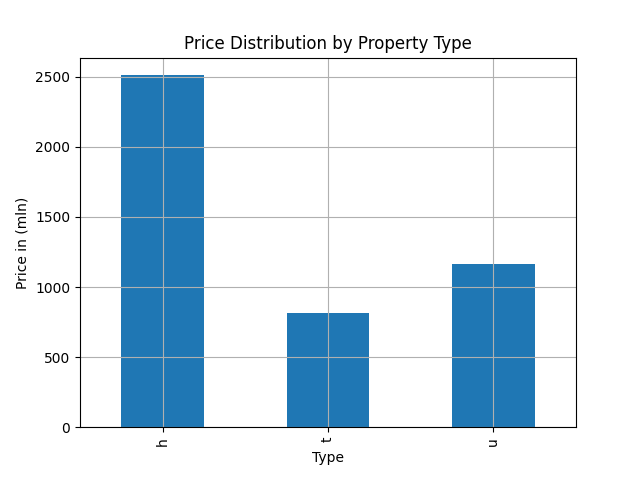

In [34]:
%matplotlib notebook 
%%python

import pandas as pd
import matplotlib.pyplot as plt

df_raw_pd = df_raw_p.toPandas() 
print(df_raw_pd.columns)

ax = df_raw_pd.groupby("Type")["Price"].nunique().plot(kind="bar")
ax.set_ylabel("Price in (mln)")
ax.set_xlabel("Type")
plt.grid()
plt.title("Price Distribution by Property Type")
plt.show()

<IPython.core.display.Javascript object>


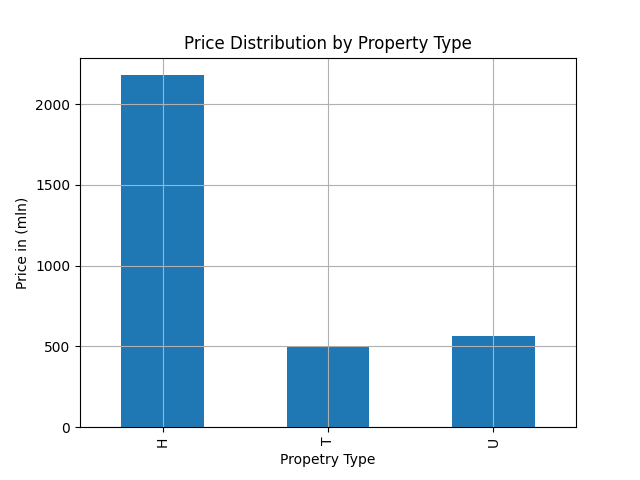

In [35]:
%matplotlib notebook 
%%python

import pandas as pd
import matplotlib.pyplot as plt

df_clean_pd = df_clean_p.toPandas() 

# H -House, T -Townhouse, U- Unit, 
ax = df_clean_pd.groupby("PropertyType")["Price"].nunique().plot(kind="bar")
ax.set_ylabel("Price in (mln)")
ax.set_xlabel("Propetry Type")
plt.grid()
plt.title("Price Distribution by Property Type")
plt.show()

### Split Data into Train/Test Balanced on Property Type in Raw Data

In [36]:
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._

//stratafied sample on propertype type
//original random sample may have been skewing the model
//used proper type as the prices vary wildly based on the type 

//idea is split into training and testing - then stratify the training set so its balanced.
def train_test_split(data: DataFrame, fraction: Double) = {
    
    //split into 80% 20%
    var Array (train, test) = data.randomSplit(Array(0.8, 0.2), seed = 30)
    
    //val sample_data = data.stat.sampleBy("PropertyType",data,36L)
    val train_fractions = Map("H" -> 0.8*fraction,"T" ->0.9*fraction, "U" -> 0.9*fraction)
    val test_fractions = Map("H" -> 0.8*fraction,"T" ->0.9*fraction, "U" -> 0.9*fraction)
    
         
    train = train.stat.sampleBy("PropertyType",train_fractions,36L)
    test = test.stat.sampleBy("PropertyType",test_fractions,36L)
    
     //sample from the data without train set 
     (train, test)
}

import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._
train_test_split: (data: org.apache.spark.sql.DataFrame, fraction: Double)(org.apache.spark.sql.Dataset[org.apache.spark.sql.Row], org.apache.spark.sql.Dataset[org.apache.spark.sql.Row])


In [37]:
//full data set
val (train, test) = train_test_split(df_clean,1)//train_test_split(test_pt,1)
//fraction of data set for finding best model
val (train_sample, test_sample) = train_test_split(df_clean,0.1)//train_test_split(test_pt,0.1)
train.cache()
test.cache()
train_sample.cache()
test_sample.cache()

train: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
test: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
train_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
test_sample: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: double, MethodOfSale: string ... 12 more fields]
res9: test_sample.type = [Price: double, MethodOfSale: string ... 12 more fields]


In [38]:
train.count()

res10: Long = 10195


In [39]:
test.count()

res11: Long = 2548


In [40]:
train_sample.count()

res12: Long = 1043


In [41]:
test_sample.count()

res13: Long = 230


### 1. Apply Linear Regression


#### Define Execution Time for LR

In [42]:
//function for getting execution time from start and end times
def getExecutionTime(start: Long , end : Long) = {
    val duration:Long = (end - start)/1000
    duration
}

getExecutionTime: (start: Long, end: Long)Long


#### Run LR Model with Default Params

Assess the training set

In [43]:
train.columns

res14: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice)


In [44]:
import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.Pipeline
val startTimeMillis = System.currentTimeMillis()

val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("scaledFeatures")
    .setPredictionCol("Predicted loggedPrice")
    .setMaxIter(100)

   val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       featureHasher,
                       new StandardScaler()
                      .setInputCol("hashedFeatures")
                      .setOutputCol("scaledFeatures")
                      .setWithStd(true).setWithMean(true),
                      lr))
     
  val result =pipeline.fit(train.drop("Price")).transform(test.drop("Price"))

val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis)+" s")


2020-06-08 13:13:22,546 WARN  [Executor task launch worker for task 49] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:13:22,555 WARN  [Executor task launch worker for task 49] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_185_1 to disk instead.
2020-06-08 13:13:22,715 WARN  [Executor task launch worker for task 48] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:13:22,716 WARN  [Executor task launch worker for task 48] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_185_0 to disk instead.
2020-06-08 13:13:33,376 WARN  [Executor task launch worker for task 49] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 2.8 GB so far)
2020-06-08 13:14:01,850 WARN  [Executor task launch worker for tas

2020-06-08 13:22:31,738 WARN  [Executor task launch worker for task 84] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:22:31,785 WARN  [Executor task launch worker for task 85] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:22:59,389 WARN  [Executor task launch worker for task 86] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:22:59,408 WARN  [Executor task launch worker for task 87] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:23:27,041 WARN  [Executor task launch worker for task 89] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-

2020-06-08 13:32:17,532 WARN  [Executor task launch worker for task 127] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:32:17,583 WARN  [Executor task launch worker for task 126] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:32:45,522 WARN  [Executor task launch worker for task 128] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:32:45,566 WARN  [Executor task launch worker for task 129] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:33:13,311 WARN  [Executor task launch worker for task 131] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)


2020-06-08 13:41:38,291 WARN  [Executor task launch worker for task 166] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:42:05,908 WARN  [Executor task launch worker for task 168] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:42:05,910 WARN  [Executor task launch worker for task 169] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:42:33,860 WARN  [Executor task launch worker for task 171] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:42:33,865 WARN  [Executor task launch worker for task 170] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)


2020-06-08 13:51:24,503 WARN  [Executor task launch worker for task 208] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:51:24,534 WARN  [Executor task launch worker for task 209] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:51:52,529 WARN  [Executor task launch worker for task 210] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 13:51:52,570 WARN  [Executor task launch worker for task 211] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 13:52:20,285 WARN  [Executor task launch worker for task 212] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)


2020-06-08 14:00:42,813 WARN  [Executor task launch worker for task 249] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 14:01:10,669 WARN  [Executor task launch worker for task 251] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)
2020-06-08 14:01:10,699 WARN  [Executor task launch worker for task 250] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 14:01:38,137 WARN  [Executor task launch worker for task 252] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_0 in memory! (computed 1901.9 MB so far)
2020-06-08 14:01:38,147 WARN  [Executor task launch worker for task 253] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_185_1 in memory! (computed 1901.9 MB so far)


import org.apache.spark.ml.regression.LinearRegression
import org.apache.spark.ml.Pipeline
startTimeMillis: Long = 1591621992288
lr: org.apache.spark.ml.regression.LinearRegression = linReg_c9aad284f599
pipeline: org.apache.spark.ml.Pipeline = pipeline_18841bb43503
result: org.apache.spark.sql.DataFrame = [MethodOfSale: string, PropertyType: string ... 18 more fields]
endTimeMillis: Long = 1591625038362


In [45]:
result.columns

res16: Array[String] = Array(MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice, SuburbIndex, StreetNameIndex, PropertyTypeIndex, MethodOfSaleIndex, hashedFeatures, scaledFeatures, Predicted loggedPrice)


#### Define LR Evaluator

In [49]:
import org.apache.spark.ml.evaluation.RegressionEvaluator

// define an evaluator 
def evaluate_lr ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("loggedPrice")
       .setPredictionCol("Predicted loggedPrice")
       .setMetricName(metric)
println(metric.toUpperCase()
        +" on test data = " + eval.evaluate(predictions))
}


import org.apache.spark.ml.evaluation.RegressionEvaluator
evaluate_lr: (predictions: org.apache.spark.sql.DataFrame, metric: String)Unit


#### Regression Metrics

**Mean squared error (MSE)** -- the average of squared differences between the predicted outcome and the true outcome.

**R2 coefficient** -- the proportion of variance in the outcome that our model is capable of predicting based on its features.


In [50]:
evaluate_lr(result,"rmse")

RMSE on test data = 0.26121842551442975


In [51]:
evaluate_lr(result,"r2")

R2 on test data = 0.727160872742109


####  Finding the Best Model (Parameter Tuning) by Cross-Validation


In [52]:
train_sample.columns

res21: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice)


In [53]:
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}


//Creates a crossvalidator on only the LR model
//Had some issues retreiving the params when using on pipeline
//and the pipeline only has one estimator in it so this was easier than traversing the stages of the pipline

val startTimeMillis = System.currentTimeMillis()

//set LR with 100 max iter
val lr = new LinearRegression()
    .setLabelCol("loggedPrice")
    .setFeaturesCol("scaledFeatures")
    .setPredictionCol("Predicted LoggedPrice")


val pipeline = new Pipeline()
    .setStages(Array(suburbIndexer,
                    streetNameIndexer,
                    propertyTypeIndexer,
                    methodOfSaleIndexer,
                    featureHasher,
                    new StandardScaler()
                    .setInputCol("hashedFeatures")
                    .setOutputCol("scaledFeatures")
                    .setWithStd(true).setWithMean(true),
                    lr))
     
// We use a ParamGridBuilder to construct a grid of parameters to search over.
val paramGrid = new ParamGridBuilder()
  .addGrid(lr.regParam, Array(0,0.1,0.5,1))
  .addGrid(lr.elasticNetParam, Array(0,0.1,0.5,1))
  .build()

// We now treat the model as an Estimator, wrapping it in a CrossValidator instance.
// This will allow us to choose best params for the model
val cv = new CrossValidator()
  .setEstimator(pipeline)
  .setEvaluator(new RegressionEvaluator()
  .setLabelCol("loggedPrice")
  .setPredictionCol("Predicted LoggedPrice")
  .setMetricName("rmse"))
  .setEstimatorParamMaps(paramGrid)
  .setNumFolds(5)  
  .setParallelism(2)


// Run cross-validation, and choose the best set of parameters.
val cvModel = cv.fit(train_sample.drop("Price"))

// Make predictions on test documents. 
//cvModel uses the best model found.
cvModel.transform(test_sample.drop("Price"))
  .select("loggedPrice", "Predicted LoggedPrice")
  .show()

//print runtime
val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis)+" s")

2020-06-08 14:15:12,623 WARN  [Executor task launch worker for task 1972] storage.BlockManager (Logging.scala:logWarning(66)) - Block rdd_2661_1 already exists on this machine; not re-adding it
+------------------+---------------------+
|       loggedPrice|Predicted LoggedPrice|
+------------------+---------------------+
|12.128111104060462|    13.00656623073618|
|12.911642346088676|   13.104193922901386|
| 12.93723789327764|   13.243159071295908|
|12.948009990259552|   13.453582954067409|
| 12.94919975839514|   13.472039445397952|
|13.001325049027272|    13.42767886809927|
|13.017002861746503|   13.504588560439128|
|13.060487973686241|   13.730218772101555|
|13.060487973686241|   13.081690459266078|
|13.112313041550827|    13.29973315860057|
|13.124361380067002|    13.75412046880001|
|13.142166004700508|   13.107603295080011|
|13.142166004700508|   13.293615382688044|
|13.146079904021645|   13.460884186349645|
|13.151922179645874|   13.453690942986963|
|13.151922179645874|   12.966163

import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.tuning.{CrossValidator, ParamGridBuilder}
startTimeMillis: Long = 1591625404923
lr: org.apache.spark.ml.regression.LinearRegression = linReg_17914fd7b74d
pipeline: org.apache.spark.ml.Pipeline = pipeline_508fef8ab117
paramGrid: Array[org.apache.spark.ml.param.ParamMap] =
Array({
	linReg_17914fd7b74d-elasticNetParam: 0.0,
	linReg_17914fd7b74d-regParam: 0.0
}, {
	linReg_17914fd7b74d-elasticNetParam: 0.0,
	linReg_17914fd7b74d-regParam: 0.1
}, {
	linReg_17914fd7b74d-elasticNetParam: 0.0,
	linReg_17914fd7b74d-regParam: 0.5
}, {
	linReg_17914fd7b74d-elasticNetParam: 0.0,
	linReg_17914fd7b74d-regParam: 1.0
}, {
	linReg_17914fd7b74d-elasticNetParam: 0.1,
	linReg_17914fd7b74d-regParam: 0.0
}, {
	linReg_17914fd7b74d-elasticNetPa...

In [54]:
cvModel.bestModel

res23: org.apache.spark.ml.Model[_] = pipeline_508fef8ab117


#### Extracting the Best Model

In [55]:
import org.apache.spark.ml.PipelineModel
import org.apache.spark.ml.regression.LinearRegressionModel

//print out the params used for the best model
val bestModel = cvModel.bestModel
val bestLRModel = bestModel.asInstanceOf[PipelineModel].stages.last.asInstanceOf[LinearRegressionModel]
println("params = " + bestLRModel.extractParamMap())

params = {
	linReg_17914fd7b74d-aggregationDepth: 2,
	linReg_17914fd7b74d-elasticNetParam: 0.1,
	linReg_17914fd7b74d-epsilon: 1.35,
	linReg_17914fd7b74d-featuresCol: scaledFeatures,
	linReg_17914fd7b74d-fitIntercept: true,
	linReg_17914fd7b74d-labelCol: loggedPrice,
	linReg_17914fd7b74d-loss: squaredError,
	linReg_17914fd7b74d-maxIter: 100,
	linReg_17914fd7b74d-predictionCol: Predicted LoggedPrice,
	linReg_17914fd7b74d-regParam: 0.1,
	linReg_17914fd7b74d-solver: auto,
	linReg_17914fd7b74d-standardization: true,
	linReg_17914fd7b74d-tol: 1.0E-6
}


import org.apache.spark.ml.PipelineModel
import org.apache.spark.ml.regression.LinearRegressionModel
bestModel: org.apache.spark.ml.Model[_] = pipeline_508fef8ab117
bestLRModel: org.apache.spark.ml.regression.LinearRegressionModel = linReg_17914fd7b74d


#### Define LR Pipeline for the Best Model

In [56]:
val lr_best = new LinearRegression()
  .setLabelCol("loggedPrice")
  .setPredictionCol("Predicted LoggedPrice")
  .setFeaturesCol("scaledFeatures")
  .setRegParam(bestLRModel.getRegParam)
  .setMaxIter(bestLRModel.getMaxIter)



val lrStages = Array(suburbIndexer,
                    streetNameIndexer,
                    propertyTypeIndexer,
                    methodOfSaleIndexer,
                    featureHasher,
                    new StandardScaler()
                    .setInputCol("hashedFeatures")
                    .setOutputCol("scaledFeatures")
                    .setWithStd(true).setWithMean(true),
                    lr_best
)

lr_best: org.apache.spark.ml.regression.LinearRegression = linReg_e3979b94e3f9
lrStages: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(strIdx_3463fa11bb00, strIdx_cddfe89225ef, strIdx_03dbaa739beb, strIdx_c40487103e32, featureHasher_77fc14242e52, stdScal_cb49de23573b, linReg_e3979b94e3f9)


In [57]:
val startTimeMillis = System.currentTimeMillis()

//define a pipleine
val lrPipe = new Pipeline().setStages(lrStages)

// We fit our DataFrame into the pipeline to generate a model
// pass best ParamMap from cross validation
val lrModel = lrPipe.fit(train)


// Make predictions using the model and the test data
// pass best ParamMap from cross validation
val predictions = lrModel.transform(test)

val endTimeMillis = System.currentTimeMillis()

print("Pipeline was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


2020-06-08 14:36:20,947 WARN  [Executor task launch worker for task 8963] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_0 in memory! (computed 1901.9 MB so far)
2020-06-08 14:36:20,948 WARN  [Executor task launch worker for task 8963] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_12016_0 to disk instead.
2020-06-08 14:36:20,971 WARN  [Executor task launch worker for task 8964] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_1 in memory! (computed 1901.9 MB so far)
2020-06-08 14:36:20,971 WARN  [Executor task launch worker for task 8964] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_12016_1 to disk instead.
2020-06-08 14:36:29,663 WARN  [Executor task launch worker for task 8964] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_1 in memory! (computed 2.8 GB so far)
2020-06-08 14:36:55,049 WARN  [Executor task l

2020-06-08 14:44:53,539 WARN  [Executor task launch worker for task 9000] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_1 in memory! (computed 1901.9 MB so far)
2020-06-08 14:45:20,513 WARN  [Executor task launch worker for task 9001] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_0 in memory! (computed 1901.9 MB so far)
2020-06-08 14:45:20,521 WARN  [Executor task launch worker for task 9002] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_1 in memory! (computed 1901.9 MB so far)
2020-06-08 14:45:47,490 WARN  [Executor task launch worker for task 9003] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_0 in memory! (computed 1901.9 MB so far)
2020-06-08 14:45:47,520 WARN  [Executor task launch worker for task 9004] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_12016_1 in memory! (computed 190

startTimeMillis: Long = 1591626976680
lrPipe: org.apache.spark.ml.Pipeline = pipeline_b8b9ecd61dc3
lrModel: org.apache.spark.ml.PipelineModel = pipeline_b8b9ecd61dc3
predictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 19 more fields]
endTimeMillis: Long = 1591628000110


In [58]:
predictions.columns

res26: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice, SuburbIndex, StreetNameIndex, PropertyTypeIndex, MethodOfSaleIndex, hashedFeatures, scaledFeatures, Predicted LoggedPrice)


#### Undo the Log Transformn on the Prediciton


In [59]:
var logtransformPredict = predictions.withColumn("Predicted loggedPrice",col("Predicted loggedPrice").cast("Double"))

logtransformPredict.withColumn("Predicted Price", exp((col("Predicted loggedPrice")))).select("Predicted Price").show(5)


+------------------+
|   Predicted Price|
+------------------+
|  309973.268043444|
|499984.91093259264|
| 389039.8086972776|
| 582436.0336031468|
|374381.45506530115|
+------------------+
only showing top 5 rows



logtransformPredict: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 19 more fields]


In [60]:
//inverse the log transform
val bestlr_predict = logtransformPredict.withColumn("Predicted Price", exp((col("Predicted loggedPrice"))))

bestlr_predict: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 20 more fields]


#### Predictions on the Best Model

In [61]:
//finesse the output of predicted price and price to aid visual compare
bestlr_predict.withColumn("Predicted Price", round($"Predicted Price", 0))
    .select("Price","Predicted Price").show()

+--------+---------------+
|   Price|Predicted Price|
+--------+---------------+
|185000.0|       309973.0|
|286000.0|       499985.0|
|288000.0|       389040.0|
|288000.0|       582436.0|
|291000.0|       374381.0|
|302500.0|       369520.0|
|305000.0|       396064.0|
|312000.0|       500956.0|
|316000.0|       538981.0|
|325000.0|       469999.0|
|326500.0|       890847.0|
|327000.0|       519483.0|
|330000.0|       765815.0|
|330000.0|       808902.0|
|347500.0|       467650.0|
|352000.0|       444616.0|
|354000.0|      1111019.0|
|355000.0|       536028.0|
|355000.0|       652894.0|
|360000.0|       472780.0|
+--------+---------------+
only showing top 20 rows



#### Regression Metrics


In [62]:
evaluate_lr(bestlr_predict,"rmse")

RMSE on test data = 0.2592235591794667


In [63]:
evaluate_lr(bestlr_predict,"r2")

R2 on test data = 0.7313121827120773


### 2. Apply Random Forest Regression

**Build Random Forest model**

Specify _numTrees, maxDepth, maxBins, featureSubsetStrategy_ and _seed_ parameters.

* **numTrees** -- Number of trees in the forest

* **maxDepth** -- Maximum depth of a tree. Increasing the depth makes the model more powerful, but deep trees take longer to train.

* **maxBins** -- Maximum number of bins used for discretizing continuous features and for choosing how to split on features at each node.

* **featureSubsetStrategy** -- Automatically select the number of features to consider for splits at each tree node

* **seed** -- Use a random seed number , allowing to repeat the results
* **MaxMemoryInMB** - Maximum memory in MB allocated to histogram aggregation.
* **CacheNodeIds** - If FALSE, the algorithm will pass trees to executors to match instances with nodes. If TRUE, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.


If the number of trees is 1, then no bootstrapping is used at all. However, if the number of trees is > 1, then the bootstrapping is accomplished. Where, the parameter _featureSubsetStrategy_ signifies the number of features to be considered for splits at each node. The supported values of _featureSubsetStrategy_ are "auto", "all", "sqrt", "log2" and "on third". The supported numerical values, on the other hand, are $(0.0-1.0]$ and $[1-n]$. However, if _featureSubsetStrategy_ is chosen as $"auto"$, the algorithm chooses the best feature subset strategy automatically


If the $numTrees == 1$, the featureSubsetStrategy is set to be "all". However, if the $numTrees > 1$ (i.e., forest), featureSubsetStrategy is set to be "onethird" for regression


Moreover, if a real value "n" is in the range $(0, 1.0]$ is set, n*number_of_features is used consequently. However, if an integer value "n" is in the range (1, the number of features) is set, only n features are used alternatively


The parameter _categoricalFeaturesInfo_ which is a map is used for storing arbitrary of categorical features. An entry $(n -> k)$ indicates that feature n is categorical with k categories indexed from $0: {0, 1,...,k-1}$
The impurity criterion used for regression is “variance”. 

The _maxDepth_ is the maximum depth of the tree. (e.g., depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). However, the suggested value is 4 to get a better result


The _maxBins_ signifies the maximum number of bins used for splitting the features; where the suggested value is 100 to get better results


Finally, the random seed is used for bootstrapping and choosing feature subsets to avoid the random nature of the results.

#### Define time Function

In [64]:
def time[R](block: => R): R = {
  val t0 = System.nanoTime()
  val result = block    // call-by-name
  val t1 = System.nanoTime()
  println("Elapsed time: " + (t1 - t0)/1000000000 + " s")
  result
 }

time: [R](block: => R)R


In [65]:
import org.apache.spark.ml.regression.RandomForestRegressor

val rf = new RandomForestRegressor()
  .setSeed(36L)
  .setLabelCol("Price")
  .setFeaturesCol("scaledFeatures")
  .setPredictionCol("prediction")
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)

rf.extractParamMap()

import org.apache.spark.ml.regression.RandomForestRegressor
rf: org.apache.spark.ml.regression.RandomForestRegressor = rfr_d630f6022c53
res31: org.apache.spark.ml.param.ParamMap =
{
	rfr_d630f6022c53-cacheNodeIds: true,
	rfr_d630f6022c53-checkpointInterval: 10,
	rfr_d630f6022c53-featureSubsetStrategy: auto,
	rfr_d630f6022c53-featuresCol: scaledFeatures,
	rfr_d630f6022c53-impurity: variance,
	rfr_d630f6022c53-labelCol: Price,
	rfr_d630f6022c53-maxBins: 32,
	rfr_d630f6022c53-maxDepth: 5,
	rfr_d630f6022c53-maxMemoryInMB: 512,
	rfr_d630f6022c53-minInfoGain: 0.0,
	rfr_d630f6022c53-minInstancesPerNode: 1,
	rfr_d630f6022c53-numTrees: 20,
	rfr_d630f6022c53-predictionCol: prediction,
	rfr_d630f6022c53-seed: 36,
	rfr_d630f6022c53-subsamplingRate: 1.0
}


In [66]:
test.columns

res32: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice)


In [67]:
train.columns

res33: Array[String] = Array(Price, MethodOfSale, PropertyType, DistanceFromCBD, Rooms, Bathroom, Car, Landsize, Latitude, Longtitude, Suburb, Date, StreetName, loggedPrice)


#### Define get_predictions Function

In [68]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline

def get_predictions[R <: Predictor[Vector, R, M],
                M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    train: DataFrame, 
    test: DataFrame) = {
    
    val pipeline = new Pipeline()
      .setStages(Array(suburbIndexer,
                       streetNameIndexer,
                       propertyTypeIndexer,
                       methodOfSaleIndexer,
                       allEncoder,
                       assembler, 
                       scaler,
                       predictor))
     
    val result =pipeline.fit(train).transform(test)
    result

}

import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
import org.apache.spark.ml.Pipeline
get_predictions: [R <: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], M <: org.apache.spark.ml.PredictionModel[org.apache.spark.ml.linalg.Vector,M]](predictor: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], train: org.apache.spark.sql.DataFrame, test: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame


In [69]:
val rfPredictions = time{get_predictions(rf, train, test)}
rfPredictions.cache()

Elapsed time: 34 s


rfPredictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 23 more fields]
res34: rfPredictions.type = [Price: double, MethodOfSale: string ... 23 more fields]


In [70]:
rfPredictions.withColumn("prediction", round($"prediction", 0)).select("Price","prediction").show(5)

+--------+----------+
|   Price|prediction|
+--------+----------+
|185000.0|  607393.0|
|286000.0|  637238.0|
|288000.0|  501286.0|
|288000.0|  701333.0|
|291000.0|  526817.0|
+--------+----------+
only showing top 5 rows



In [71]:
rfPredictions.describe().select("summary","Price","prediction").show()

+-------+-----------------+------------------+
|summary|            Price|        prediction|
+-------+-----------------+------------------+
|  count|             2548|              2548|
|   mean|1160930.008634223|1147004.4470918612|
| stddev|675320.2767043534| 386417.1674604188|
|    min|         185000.0|495424.37769344856|
|    max|        6370000.0|3293346.3098556255|
+-------+-----------------+------------------+



#### Regression Metrics


In [72]:

def assess_rf ( predictions: DataFrame, metric: String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol("Price")
       .setPredictionCol("prediction")
       .setMetricName(metric)
println(metric.toUpperCase()+" on test data = " + eval.evaluate(predictions))
    
}

assess_rf: (predictions: org.apache.spark.sql.DataFrame, metric: String)Unit


In [73]:
assess_rf(rfPredictions,"rmse")

RMSE on test data = 423798.832023332


In [74]:
assess_rf(rfPredictions,"r2")

R2 on test data = 0.6060234161269165


####  Finding the Best Model (Parameter Tuning) by Cross-Validation


In [75]:
import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel



def train_eval[R <: Predictor[Vector, R, M],
               M <: PredictionModel[Vector, M]](
    predictor: Predictor[Vector, R, M],
    paramMap: Array[ParamMap],
    train: DataFrame, 
    test: DataFrame) = {

    val pipeline = new Pipeline()
      .setStages(Array(
          suburbIndexer,
          streetNameIndexer,
          propertyTypeIndexer,
          methodOfSaleIndexer,
          allEncoder,
          assembler, 
          scaler,
          predictor))
    
    val cv = new CrossValidator()
        .setEstimator(pipeline)
        .setEvaluator(new RegressionEvaluator()
        .setLabelCol("Price")
        .setPredictionCol("prediction")
        .setMetricName("rmse"))
        .setEstimatorParamMaps(paramMap)
        .setNumFolds(5)
        .setParallelism(2)

    val cvModel = cv.fit(train)
    val predictions = cvModel.transform(test)
    
    predictions.cache()
   
    val bestModel = cvModel.bestModel
    
    println(bestModel.extractParamMap)
    
    bestModel
}


import org.apache.spark.ml.Predictor
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.PredictionModel
train_eval: [R <: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], M <: org.apache.spark.ml.PredictionModel[org.apache.spark.ml.linalg.Vector,M]](predictor: org.apache.spark.ml.Predictor[org.apache.spark.ml.linalg.Vector,R,M], paramMap: Array[org.apache.spark.ml.param.ParamMap], train: org.apache.spark.sql.DataFrame, test: org.apache.spark.sql.DataFrame)org.apache.spark.ml.Model[_]


In [76]:
import org.apache.spark.ml.regression.RandomForestRegressor

// Models hyperparameters
val numTrees = Seq(5,10,20,30,50,100)
val maxBins = Seq(32,50,100)
val maxDepth = Seq(2,3,5)
//val featureSubsetStrategy = Seq("sqrt","onethird")

val rf = new RandomForestRegressor()
  .setSeed(36L)
  .setLabelCol("Price")
  .setFeaturesCol("scaledFeatures")
  .setPredictionCol("prediction")
  .setImpurity("variance")
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)


val rfParamMap = new ParamGridBuilder()
  .addGrid(rf.numTrees, numTrees)
  .addGrid(rf.maxDepth, maxDepth)
  .addGrid(rf.maxBins, maxBins)
  .build()

val tStart = System.nanoTime()
val best_model = train_eval(rf, rfParamMap, train, test)
val tEnd = System.nanoTime()

print("Model was executed "
      + getExecutionTime(tStart/1000000,tEnd/1000000)+" s")

{

}
Model was executed 3994 s

import org.apache.spark.ml.regression.RandomForestRegressor
numTrees: Seq[Int] = List(5, 10, 20, 30, 50, 100)
maxBins: Seq[Int] = List(32, 50, 100)
maxDepth: Seq[Int] = List(2, 3, 5)
rf: org.apache.spark.ml.regression.RandomForestRegressor = rfr_fe3daf09aef5
rfParamMap: Array[org.apache.spark.ml.param.ParamMap] =
Array({
	rfr_fe3daf09aef5-maxBins: 32,
	rfr_fe3daf09aef5-maxDepth: 2,
	rfr_fe3daf09aef5-numTrees: 5
}, {
	rfr_fe3daf09aef5-maxBins: 32,
	rfr_fe3daf09aef5-maxDepth: 2,
	rfr_fe3daf09aef5-numTrees: 10
}, {
	rfr_fe3daf09aef5-maxBins: 32,
	rfr_fe3daf09aef5-maxDepth: 2,
	rfr_fe3daf09aef5-numTrees: 20
}, {
	rfr_fe3daf09aef5-maxBins: 32,
	rfr_fe3daf09aef5-maxDepth: 2,
	rfr_fe3daf09aef5-numTrees: 30
}, {
	rfr_fe3daf09aef5-maxBins: 32,
	rfr_fe3daf09aef5-maxDepth: 2,
	rfr_fe3daf09aef5-num...

### Extracting the Best Model

In [77]:
import org.apache.spark.ml.regression.RandomForestRegressionModel

val bestPipelineModel = best_model.asInstanceOf[PipelineModel]

val stages = bestPipelineModel.stages
for (i <- stages) println

val bestRFModel = stages.last.asInstanceOf[RandomForestRegressionModel]

println("RF params = " + bestRFModel.extractParamMap())










RF params = {
	rfr_fe3daf09aef5-cacheNodeIds: true,
	rfr_fe3daf09aef5-checkpointInterval: 10,
	rfr_fe3daf09aef5-featureSubsetStrategy: auto,
	rfr_fe3daf09aef5-featuresCol: scaledFeatures,
	rfr_fe3daf09aef5-impurity: variance,
	rfr_fe3daf09aef5-labelCol: Price,
	rfr_fe3daf09aef5-maxBins: 100,
	rfr_fe3daf09aef5-maxDepth: 5,
	rfr_fe3daf09aef5-maxMemoryInMB: 512,
	rfr_fe3daf09aef5-minInfoGain: 0.0,
	rfr_fe3daf09aef5-minInstancesPerNode: 1,
	rfr_fe3daf09aef5-numTrees: 20,
	rfr_fe3daf09aef5-predictionCol: prediction,
	rfr_fe3daf09aef5-seed: 36,
	rfr_fe3daf09aef5-subsamplingRate: 1.0
}


import org.apache.spark.ml.regression.RandomForestRegressionModel
bestPipelineModel: org.apache.spark.ml.PipelineModel = pipeline_5d2eb89b2887
stages: Array[org.apache.spark.ml.Transformer] = Array(strIdx_3463fa11bb00, strIdx_cddfe89225ef, strIdx_03dbaa739beb, strIdx_c40487103e32, oneHotEncoder_32532d9cc924, vecAssembler_3107d3d55de1, stdScal_7ca98adda80b, RandomForestRegressionModel (uid=rfr_fe3daf09aef5) with 20 trees)
bestRFModel: org.apache.spark.ml.regression.RandomForestRegressionModel = RandomForestRegressionModel (uid=rfr_fe3daf09aef5) with 20 trees


#### Prediction on the Best Model

In [78]:
val seed = 5043
val rf_best = new RandomForestRegressor()
  .setSeed(seed)
  .setLabelCol("Price")
  .setNumTrees(bestRFModel.getNumTrees)
  .setMaxDepth(bestRFModel.getMaxDepth)
  .setMaxBins(bestRFModel.getMaxBins)
  .setMaxMemoryInMB(512)
  .setCacheNodeIds(true)

val rf_best_Predictions = time{get_predictions(rf_best, train, test)}
rfPredictions.cache()

Elapsed time: 11 s
2020-06-08 17:27:28,147 WARN  [Thread-4] execution.CacheManager (Logging.scala:logWarning(66)) - Asked to cache already cached data.


seed: Int = 5043
rf_best: org.apache.spark.ml.regression.RandomForestRegressor = rfr_c62109dd9569
rf_best_Predictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale: string ... 23 more fields]
res41: rfPredictions.type = [Price: double, MethodOfSale: string ... 23 more fields]


#### Regression Metrics on the Best Model


In [79]:
assess_rf(rf_best_Predictions,"rmse")

RMSE on test data = 422428.83685602905


In [80]:
assess_rf(rf_best_Predictions,"r2")

R2 on test data = 0.6085664793401491


### 3. Apply K-means Model  

Unsupervised learning problem. To find opimal number of clusters run many models with differnet numer of clusters. When the number of clusters increses the differences between clusters gets smaller while the differences between points inside clusters increase as well. Optimally, WCSSE -  Within Set Sum of Squared Errors, should be as small as possible, while Slhouette coefficient lies in the interval [-1,1] and is a measure of cohesion inside the clusters and separation between the clusters should get as close to 1 as possible.

* WSSSE -  Within Set Sum of Squared Errors
* Slhouette coefficient  for a data point is  $(b-a)/max(a,b)$, where $a$ - measure of cohesion (mean intra-cluster distance), b - measure of separarion (the distance between a sample and the nearest cluster that the sample is not a part of)


#### Splitting & Hashing 

Because K-Means requires to include the "Price" feature to create the clusters in the training data but to exclude from the test data for accuracy, new splitting and hashing need to be utilised.

In [ ]:
train.printSchema()

In [83]:
val indexers = Array("Suburb","StreetName","MethodOfSale","PropertyType").map { colName =>
  new StringIndexer()
    .setInputCol(colName)
    .setOutputCol(colName + "_Ind")
}

// Create a pipeline which exacutes the indexing of the string type features
val pipeline = new Pipeline().setStages(indexers)

// Create a Vector of the Features to be used for Training & Testing
def vectorise(data: DataFrame, col1:String, col2:String) = {
    
    val assembler = new VectorAssembler()
        .setInputCols(data.drop(col1,col2).columns)
        .setOutputCol("features")
    
    (assembler.transform(data))
}


indexers: Array[org.apache.spark.ml.feature.StringIndexer] = Array(strIdx_ae16616eb85a, strIdx_ddb21bc2e7e5, strIdx_ffc6fbc962c7, strIdx_c9e962db593b)
pipeline: org.apache.spark.ml.Pipeline = pipeline_caf1994a0a4b
vectorise: (data: org.apache.spark.sql.DataFrame, col1: String, col2: String)org.apache.spark.sql.DataFrame


In [85]:
// Training Data Vectorising and Reordering the Columns
val strIndex_train = pipeline.fit(train).transform(train).drop("StreetName",
                                                               "Suburb",
                                                               "MethodOfSale",
                                                               "PropertyType"
                                                              ).select("Price",
                                                                       "MethodOfSale_Ind",
                                                                       "PropertyType_Ind",
                                                                       "DistanceFromCBD",
                                                                       "Rooms",
                                                                       "Bathroom",
                                                                       "Car",
                                                                       "Landsize", 
                                                                       "Latitude", 
                                                                       "Date", 
                                                                       "Suburb_Ind", 
                                                                       "StreetName_Ind",
                                                                       "loggedPrice")

val kmeans_train = vectorise(strIndex_train,"Price","")

kmeans_train.printSchema()


root
 |-- Price: double (nullable = true)
 |-- MethodOfSale_Ind: double (nullable = false)
 |-- PropertyType_Ind: double (nullable = false)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Date: long (nullable = true)
 |-- Suburb_Ind: double (nullable = false)
 |-- StreetName_Ind: double (nullable = false)
 |-- loggedPrice: double (nullable = true)
 |-- features: vector (nullable = true)



strIndex_train: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 11 more fields]
kmeans_train: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 12 more fields]


In [86]:
// Test Data Vectorising and Reordering the Columns
val strIndex_test = pipeline.fit(test).transform(test).drop("StreetName",
                                                               "Suburb",
                                                               "MethodOfSale",
                                                               "PropertyType"
                                                              ).select("Price",
                                                                       "MethodOfSale_Ind",
                                                                       "PropertyType_Ind",
                                                                       "DistanceFromCBD",
                                                                       "Rooms",
                                                                       "Bathroom",
                                                                       "Car",
                                                                       "Landsize", 
                                                                       "Latitude", 
                                                                       "Date", 
                                                                       "Suburb_Ind", 
                                                                       "StreetName_Ind",
                                                                       "loggedPrice")

val kmeans_test = vectorise(strIndex_test,"Price","loggedPrice")

kmeans_test.printSchema()


root
 |-- Price: double (nullable = true)
 |-- MethodOfSale_Ind: double (nullable = false)
 |-- PropertyType_Ind: double (nullable = false)
 |-- DistanceFromCBD: double (nullable = true)
 |-- Rooms: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Car: integer (nullable = true)
 |-- Landsize: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Date: long (nullable = true)
 |-- Suburb_Ind: double (nullable = false)
 |-- StreetName_Ind: double (nullable = false)
 |-- loggedPrice: double (nullable = true)
 |-- features: vector (nullable = true)



strIndex_test: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 11 more fields]
kmeans_test: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 12 more fields]


#### Training 


In [88]:
import org.apache.spark.ml.clustering.{KMeans,KMeansModel}

val startTimeMillis = System.currentTimeMillis()

// Get the count on training data
val count = kmeans_train.count()

// Get the number of clusters by deciding on the amount of properties to have in each cluster
val k = (count/200).toInt

// Trains a k-means model.
val kmeans = new KMeans()
    .setK(k)
    .setSeed(7L) // Random seed
    .setFeaturesCol("features")
    .setPredictionCol("prediction")

// Define the Training Model of K-Means
val model = kmeans.fit(kmeans_train.select("features"))

// Print runtime
val endTimeMillis = System.currentTimeMillis()

print("Model was executed "
      + getExecutionTime(startTimeMillis,endTimeMillis))


Model was executed 1

import org.apache.spark.ml.clustering.{KMeans, KMeansModel}
startTimeMillis: Long = 1591654808866
count: Long = 10195
k: Int = 50
kmeans: org.apache.spark.ml.clustering.KMeans = kmeans_25f565326ad5
model: org.apache.spark.ml.clustering.KMeansModel = kmeans_25f565326ad5
endTimeMillis: Long = 1591654810624


#### Prediction

Manually find the closest cluster based on its Euclidean distance.
Once found, assign the cluster's Price as a prediction and then test it.

In [ ]:
import org.apache.spark.ml.clustering.{KMeans,KMeansModel}

val kmeans = new KMeans().setSeed(5043L)
                         .setPredictionCol("cluster")
                         .setFeaturesCol("scaledFeatures")


In [90]:
import math._
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.linalg.Vectors

def ecldnDist(feature:Vector):Double = {
    var dist = 1000000000000000000000.0 // Initialise Distance variable, with a high value to ensure first result is lesser
    var price:Double = 0.0 // Initialise the predicted Price Variable
    
    // Iterate though all Clusters Centres for this Row
    for (cluster <- model.clusterCenters){

        var cl_clean = Vectors.dense(cluster.toArray.slice(0,11)) // Drops the price from the clusters

        // Get the Euclidean Distance of Row's Features Vector & Cluster Vector.
        var r_dist = sqrt(Vectors.sqdist(feature,cl_clean))

        // Check if calculated distanct is less than the previous one.
        if (r_dist < dist) {dist = r_dist // Assigns Smaller Distance
                            price = cluster.toArray.apply(11)} // Assigns Cluster Price of Current Smallest Distance     
    }
    return price // Returns the Price from the Custer with the smallest distance from this row.
}

// Creates the Input and Calculation for Distance
val distance = (feature:Vector) => {ecldnDist(feature)}
// Creates the User Defined Function from the Distance calcuation
val DistFromCluster = udf(distance)

import math._
import org.apache.spark.ml.linalg.Vector
import org.apache.spark.ml.linalg.Vectors
ecldnDist: (feature: org.apache.spark.ml.linalg.Vector)Double
distance: org.apache.spark.ml.linalg.Vector => Double = <function1>
DistFromCluster: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,DoubleType,Some(List(org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7)))


In [91]:
import org.apache.spark.sql.functions._

// Creates a new DataFrame from the test DataFrame
val kmeans_predict = kmeans_test.withColumn("loggedPrediction",DistFromCluster(col("features")))
                                .withColumn("Prediction", exp(col("loggedPrediction")))

// Display acatual and predicted Price
kmeans_predict.select("Price","Prediction","loggedPrice","loggedPrediction").show()


+--------+------------------+------------------+------------------+
|   Price|        Prediction|       loggedPrice|  loggedPrediction|
+--------+------------------+------------------+------------------+
|185000.0| 973533.9837894678|12.128111104060462|13.788688012059737|
|286000.0| 870818.8085811978| 12.56374708980199|13.677189207306787|
|288000.0| 1151399.988978017|12.570715759118084|13.956489141651167|
|288000.0|1031081.5555729611|12.570715759118084|13.846118863239127|
|291000.0|1097221.8773479369|12.581078546153629|13.908291977099386|
|302500.0| 997637.2812438598|12.619836556453032| 13.81314504358379|
|305000.0| 997637.2812438598|12.628067055589549| 13.81314504358379|
|312000.0|1061109.2453129117| 12.65075846679162|13.874825376775295|
|316000.0| 909345.7110506814| 12.66349749256905|13.720480621043993|
|325000.0|1077296.5286158721|12.691580461311874|13.889965246576779|
|326500.0|1081608.0443909555|12.696185227698622|13.893959421734817|
|327000.0|1041194.2493288394|12.697715449879391|

import org.apache.spark.sql.functions._
kmeans_predict: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 14 more fields]


#### Tuning the model: choosing number of clusters


Evaluate the quality of clustering by "elbowing" the Within Set Sum of Squared Errors (WSSSE) graph.

In [95]:
// define an evaluator for the cross validation
def assess_kmeans ( predictions: DataFrame, metric: String, Label:String, Predicted:String) = {
    val eval =  new RegressionEvaluator()
       .setLabelCol(Label)
       .setPredictionCol(Predicted)
       .setMetricName(metric)
println(metric.toUpperCase()
        +" on test data = " + eval.evaluate(predictions))
}

assess_kmeans: (predictions: org.apache.spark.sql.DataFrame, metric: String, Label: String, Predicted: String)Unit


In [96]:
assess_kmeans(kmeans_predict,"rmse", "Price", "Prediction")
assess_kmeans(kmeans_predict,"r2", "Price", "Prediction")


RMSE on test data = 687448.5690973068
R2 on test data = -0.036648023222835446


In [97]:
// Evaluating model on Logged Prices
assess_kmeans(kmeans_predict,"rmse", "loggedPrice", "loggedPrediction")
assess_kmeans(kmeans_predict,"r2", "loggedPrice", "loggedPrediction")


RMSE on test data = 0.4963851651071106
R2 on test data = 0.014772275830187365


In [103]:
// Make clustering predictions
val predictions = model.transform(kmeans_train)

predictions: org.apache.spark.sql.DataFrame = [Price: double, MethodOfSale_Ind: double ... 13 more fields]


In [104]:
// Within Set Sum of Squared Errors
val WSSSE = model.computeCost(kmeans_train)

println("WSSSE error " + WSSSE)


WSSSE error 8.296803634448306E12


WSSSE: Double = 8.296803634448306E12


In [105]:
import org.apache.spark.ml.evaluation.ClusteringEvaluator

// Evaluate clustering by computing Silhouette score
val evaluator = new ClusteringEvaluator()

val silhouette = evaluator.evaluate(predictions)
println(s"Silhouette with squared euclidean distance = $silhouette")

Silhouette with squared euclidean distance = 0.9044180211036867


import org.apache.spark.ml.evaluation.ClusteringEvaluator
evaluator: org.apache.spark.ml.evaluation.ClusteringEvaluator = cluEval_78d7eff955a4
silhouette: Double = 0.9044180211036867


#### Optimise K value

In [109]:
// Initialise the Map
var best_WSSSE = scala.collection.mutable.Map[Int,Double]()
var best_Silh = scala.collection.mutable.Map[Int,Double]()

for (p <- 10 to 300 by 10){

    // Get the number of clusters by deciding on the amount of data points to have in each cluster
    val k = (kmeans_training.count()/p).toInt
    
    // Trains a k-means model.
    val kmeans = new KMeans()
    .setK(k)
    .setSeed(7L) // Random seed
    .setFeaturesCol("features")
    .setPredictionCol("prediction")

    // Define the Training Model of K-Means
    val model = kmeans.fit(kmeans_train.select("features"))
    // Make Clustering predictions
    val predictions = model.transform(kmeans_train)
    
    // Within Set Sum of Squared Errors
    val WSSSE = model.computeCost(kmeans_train)
    // Append the p value (property count per cluster) and WSSSE in the Map
    best_WSSSE += k -> WSSSE
    // Clustering Silhouette
    val silhouette = evaluator.evaluate(predictions)
    // Append the p value (property count per cluster) and Silhouette Score in the Map
    best_Silh += k -> silhouette
}

best_WSSSE: scala.collection.mutable.Map[Int,Double] = Map(92 -> 7.001114449439612E12, 101 -> 6.423539686884444E12, 254 -> 5.99411879365806E11, 113 -> 4.913530624124615E12, 1019 -> 4.873542011968228E10, 59 -> 8.2858933581569375E12, 50 -> 8.296803634448306E12, 35 -> 1.937505399002961E13, 53 -> 9.215747961377908E12, 44 -> 1.5307196910916209E13, 56 -> 7.375377665400225E12, 169 -> 6.040809283633082E11, 127 -> 1.273146526643202E12, 46 -> 1.5592662285355186E13, 145 -> 6.072583098837406E11, 67 -> 7.625075500775409E12, 40 -> 1.6585845734998344E13, 339 -> 5.980388033158956E11, 37 -> 1.8038315008069004E13, 509 -> 5.970080507454269E11, 78 -> 7.014796624907247E12, 63 -> 7.04193640482158E12, 72 -> 7.624576680922204E12, 36 -> 1.8750028936776793E13, 84 -> 7.006496694033419E12, 48 -> 1.5261873523995467...

In [130]:
// Optimal number of clasters minimising WSSSE metircs
val k_best_wssse = best_WSSSE.minBy(_._2)._1

k_best_wssse: Int = 1019


In [131]:
// Optimal number of clusters maximising Silhouette 
val k_best_silh = best_Silh.maxBy(_._2)._1

k_best_silh: Int = 50


In [134]:
//Best wssse
 best_WSSSE.minBy(_._2)._2

res83: Double = 4.873542011968228E10


In [136]:
4.873542011968228E10/10195

res85: Double = 4780325.661567659


In [123]:
val pnt_count = kmeans_train.count().toInt

pnt_count: Int = 10195


In [132]:
//Number of observations per cluster minimising WSSSE metircs
pnt_count/k_best_wssse

res81: Int = 10


In [133]:
//Number of observations per cluster maximising the Silhouette coefficient
pnt_count/k_best_silh

res82: Int = 203


In [135]:
//Best Silhouette coefficient
best_Silh.maxBy(_._2)._2

res84: Double = 0.9044180211104262


As seen above the the number of observations per cluster which minimises the WSSSE is 10. It makes sense as the less values are within a cluster the more accurate is a prediction

However, as the Silhouette coefficient indicates how well the data fits with its clusters it suggests 230 is a better number of observations per cluster.

### References

Apache Spark (n.d.). _Spark ML Programming Guide._ Retrieved from https://spark.apache.org/docs/1.2.2/ml-guide.html

Bahadoor N., (2020). _Spark tutorials_ Retrieved from https://allaboutscala.com/big-data/spark/
Gorczynski M. (2017). _Introduction to machine learning with spark and mllib (dataframe API)._ Retrieved from https://scalac.io/scala-spark-ml-machine-learning-introduction/

Hydrospheredata (2020). Program creek. Scala Code Examples. Scaler Retrieved from https://www.programcreek.com/scala/org.apache.spark.ml.feature.StandardScaler

Jen G. (2020) _FeatureHasher_. Retrieved from https://george-jen.gitbook.io/data-science-and-apache-spark/featurehasher

Johnson S (2019). _From sckit-learn to Spark ML._ Retrieved from https://towardsdatascience.com/from-scikit-learn-to-spark-ml-f2886fb46852

Johnson S (2019). _Housing Prices - Spark ML Project_ Retrieved from https://github.com/scottdjohnson/HousingPricePredictions/blob/master/HousingPrices-SparkML.ipynb

Masri A. (2019). _FeatureTransformation. Retrieved from
https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e

Poddutur S. (). _Distribution of Executors, Cores and Memory for a Spark Application running in Yarn:_ Retrieved from https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html 

Rai D.,(2018) _Feature Engineering in pyspark — Part I._ Retrieved from https://medium.com/@dhiraj.p.rai/essentials-of-feature-engineering-in-pyspark-part-i-76a57680a85

Sarkar A. (2017). _Learning Spark SQL. Implementing a Spark ML clustering model._ Packt Publishing.

Scala Doc (n.d.) Retrieved from https://docs.scala-lang.org


(2019) _Random Forest Classifier with Apache Spark_ Retireved from https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc

Wagle M.(2020) _Predicting House Prices using Machine Learning_. Retrieved from https://medium.com/@manilwagle/predicting-house-prices-using-machine-learning-cab0b82cd3f


Zecevic P., Bonaci M. (2020) _Spark in Action_ Retireved from https://livebook.manning.com/book/spark-in-action/about-this-book/